In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from datetime import datetime
from datetime import timedelta
import matplotlib.cm as cm

C:\Users\david\AppData\Local\Temp\ipykernel_14400\3864594335.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def calc_NSE(Qo, Qm):
    QoAv  = np.mean(Qo)
    ErrUp = np.sum((Qo - Qm)**2)
    ErrDo = np.sum((Qo - QoAv)**2)
    return 1 - (ErrUp / ErrDo)
    
def calc_log_NSE(Qo, Qm):
    Qo[Qo == 0] = 1e-6
    QoAv  = np.mean(Qo)
    ErrUp = np.sum((np.log(Qo) - np.log(Qm))**2)
    ErrDo = np.sum((np.log(Qo) - np.log(QoAv))**2)
    return 1 - (ErrUp / ErrDo)

In [3]:
path = Path.cwd() 
figure_path = path / "Figures"

In [17]:
path

WindowsPath('D:/work/Studie TUD/Msc/Year 6/Q3 Thesis/Code/eWaterCycle-WSL-WIP/nbs_43_analyse_diff_best_callibrate')

### DA best ensemble member

In [21]:
best_ds_files = list((path.parent / "nbs_42_also_store_Q_best" / 'Output' / 'first_26').glob("*.nc"))

In [23]:
best_ds_lst = []
for file in best_ds_files:
    best_ds_lst.append(xr.open_dataset(file))

In [24]:
df_best = pd.DataFrame(columns=["NSE_mean_DA","log_NSE_mean_DA","NSE_best_DA","log_NSE_best_DA","path_DA"],)
for ds in best_ds_lst:
    uid = ds.attrs['HRU_id']
    df_best.loc[uid, 'NSE_mean_DA'] = calc_NSE(ds["Q_obs"].values, ds["Q"].sel(summary_stat="mean").values)
    df_best.loc[uid, 'log_NSE_mean_DA'] = calc_log_NSE(ds["Q_obs"].values, ds["Q"].sel(summary_stat="mean").values)
    df_best.loc[uid, 'NSE_best_DA'] = calc_NSE(ds["Q_obs"].values, ds["Q"].sel(summary_stat="best").values)
    df_best.loc[uid, 'log_NSE_best_DA'] = calc_log_NSE(ds["Q_obs"].values, ds["Q"].sel(summary_stat="best").values)
    df_best.loc[uid,'path_DA'] = file

In [25]:
df_best.head(3)

,NSE_mean_DA,log_NSE_mean_DA,NSE_best_DA,log_NSE_best_DA,path_DA
01013500,0.57813,-0.55511,0.861828,0.662818,D:\work\Studie TUD\Msc\Year 6\Q3 Thesis\Code\e...
01022500,0.521113,0.541622,0.655206,0.706836,D:\work\Studie TUD\Msc\Year 6\Q3 Thesis\Code\e...
01030500,0.15002,0.319357,0.412902,0.476651,D:\work\Studie TUD\Msc\Year 6\Q3 Thesis\Code\e...


### calibration

In [26]:
callibration_ds_files = list((path.parent / "nbs_41_callibration" / 'Output').glob("*.nc"))

In [27]:
cal_ds_lst = []
for file in callibration_ds_files:
    cal_ds_lst.append(xr.open_dataset(file))

In [28]:
cal_ds_lst[0]

<xarray.Dataset>
Dimensions:         (EnsembleMember: 2, time: 1857)
Coordinates:
  * EnsembleMember  (EnsembleMember) int64 308 443
  * time            (time) datetime64[ns] 1997-08-01 1997-08-02 ... 2002-08-31
Data variables: (12/16)
    Imax            (EnsembleMember, time) float64 ...
    Ce              (EnsembleMember, time) float64 ...
    Sumax           (EnsembleMember, time) float64 ...
    Beta            (EnsembleMember, time) float64 ...
    Pmax            (EnsembleMember, time) float64 ...
    Tlag            (EnsembleMember, time) float64 ...
    ...              ...
    Su              (EnsembleMember, time) float64 ...
    Sf              (EnsembleMember, time) float64 ...
    Ss              (EnsembleMember, time) float64 ...
    Sp              (EnsembleMember, time) float64 ...
    Q               (EnsembleMember, time) float64 ...
    Q_obs           (time) float64 ...
Attributes:
    title:          HBV storage & parameter terms data over time for 500 part...
    history:        Storage term results from ewatercycle_HBV.model
    n_particles:    500
    HRU_id:         01013500
    NSE_max:        0.8000585706940022
    log_NSE_max:    0.7713077092046793
    i_NSE_max:      308
    i_log_NSE_max:  443

In [29]:
df_cal = pd.DataFrame(columns=["NSE_cal","log_NSE_cal","path_cal"],)
for ds in cal_ds_lst:
    uid = ds.attrs['HRU_id']
    df_cal.loc[uid, 'NSE_cal'] = ds.attrs['NSE_max']
    df_cal.loc[uid, 'log_NSE_cal'] = ds.attrs['log_NSE_max']
    df_cal.loc[uid,'path_cal'] = file

In [30]:
df_cal.head(3)

,NSE_cal,log_NSE_cal,path_cal
01013500,0.800059,0.771308,D:\work\Studie TUD\Msc\Year 6\Q3 Thesis\Code\e...
01022500,0.640479,0.790192,D:\work\Studie TUD\Msc\Year 6\Q3 Thesis\Code\e...
01030500,0.437132,0.631559,D:\work\Studie TUD\Msc\Year 6\Q3 Thesis\Code\e...


In [31]:
df = pd.concat([df_cal,df_best],axis=1)

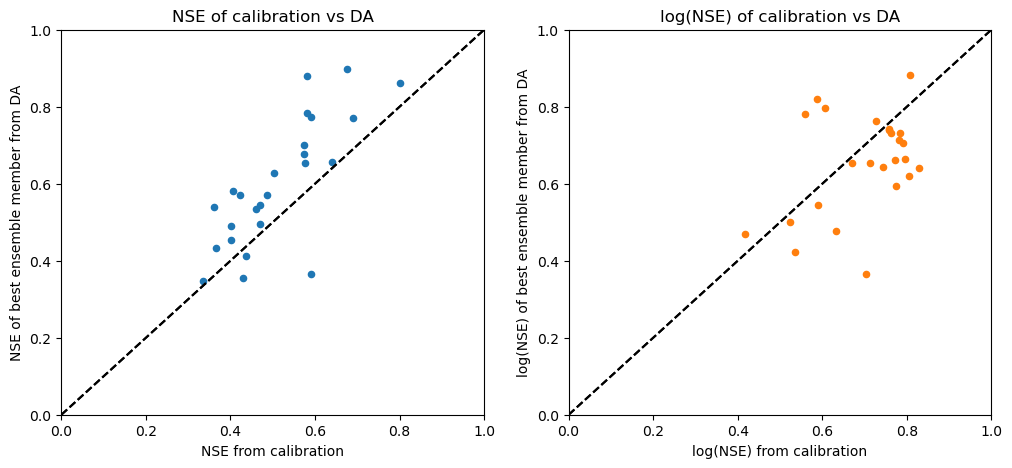

In [32]:
fig, axs = plt.subplots(1,2,figsize=(12,5))
ax = axs[0]
df.plot.scatter('NSE_cal','NSE_best_DA',ax=ax,color="C0")
ax.set_xlabel("NSE from calibration")
ax.set_ylabel("NSE of best ensemble member from DA")
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.plot([[0,0],[1,1]],color="k",ls="--")
ax.set_title('NSE of calibration vs DA')

ax = axs[1]
df.plot.scatter('log_NSE_cal','log_NSE_best_DA',ax=ax,color="C1")
ax.set_xlabel("log(NSE) from calibration")
ax.set_ylabel("log(NSE) of best ensemble member from DA")
ax.set_title('log(NSE) of calibration vs DA')
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.plot([[0,0],[1,1]],color="k",ls="--");

fig.savefig(figure_path / 'NSE_comparison.png',bbox_inches='tight',dpi=150)

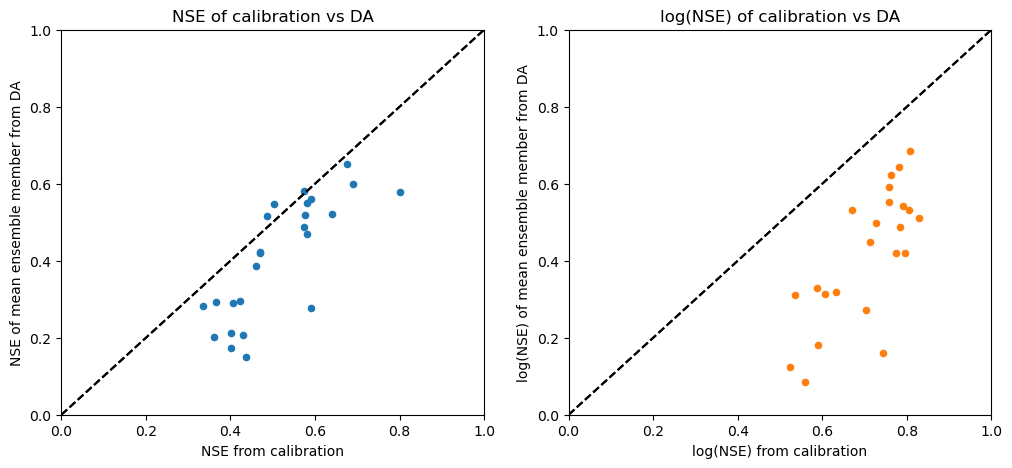

In [33]:
fig, axs = plt.subplots(1,2,figsize=(12,5))
ax = axs[0]
df.plot.scatter('NSE_cal','NSE_mean_DA',ax=ax,color="C0")
ax.set_xlabel("NSE from calibration")
ax.set_ylabel("NSE of mean ensemble member from DA")
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.plot([[0,0],[1,1]],color="k",ls="--")
ax.set_title('NSE of calibration vs DA')

ax = axs[1]
df.plot.scatter('log_NSE_cal','log_NSE_mean_DA',ax=ax,color="C1")
ax.set_xlabel("log(NSE) from calibration")
ax.set_ylabel("log(NSE) of mean ensemble member from DA")
ax.set_title('log(NSE) of calibration vs DA')
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.plot([[0,0],[1,1]],color="k",ls="--");

fig.savefig(figure_path / 'NSE_comparison.png',bbox_inches='tight',dpi=150)